In [23]:
# ben doesn't believe me again
# kinda getting sick of this clerical stuff
# i know my fisher information matrix is valid
# i know my likelihood is valid
# ive tested it against theoretical bounds and it works
# and yet its like i have to reproduce every single previous result
# and they still wont believe me

# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'

from pathlib import Path

In [29]:
wf_npix = 256 
diameter = 0.125 # This is default of toliman optical system. Can change.

psf_npix = 128
psf_pixel_scale = 0.375
oversample = 4

# might try with different separation... this could be really bad /interesting I REALLY hope they knew what they were doing
source = dlT.AlphaCen(separation=6.0)

mean_wl = source.wavelengths.mean()

# Construct instrument
optics = TolimanOpticalSystem(wf_npixels=wf_npix,psf_npixels=psf_npix,
                            radial_orders=[2, 3], psf_pixel_scale=psf_pixel_scale, oversample=oversample)

model = dl.Telescope(optics, source)

In [30]:
shape_dict = {'wavelengths': (1,)}
marginal_params = ['separation', 'position_angle', 'x_position', 'y_position', 'log_flux', 'contrast', 'wavelengths', 
    'psf_pixel_scale', 'aperture.coefficients']

In [31]:
# no grating
from copy import deepcopy

def strip_layer(optics, layer_name="pupil"):
    # Get items in a uniform way
    if isinstance(optics.layers, dict):
        items = list(optics.layers.items())
    else:
        items = list(optics.layers)  # already list of (name, layer)

    # Build the new layers as a list of (name, layer) tuples
    new_layers = []
    for name, layer in items:
        if name == layer_name:
            continue
        # must be (str, OpticalLayer) — not strings, not names only
        new_layers.append((name, deepcopy(layer)))

    # Construct a plain AngularOpticalSystem with the pupil removed
    return dl.AngularOpticalSystem(
        wf_npixels      = optics.wf_npixels,
        diameter        = optics.diameter,
        layers          = new_layers,              # <-- list of (name, OpticalLayer)
        psf_npixels     = optics.psf_npixels,
        oversample      = optics.oversample,
        psf_pixel_scale = optics.psf_pixel_scale,
    )

central_optics = strip_layer(model.optics, "pupil")
model_airy = dl.Telescope(
    optics = central_optics,
    source = source
)

data_airy = model_airy.model()
cov_airy = zdx.covariance_matrix(model_airy, marginal_params, poiss_loglike, data=data_airy, shape_dict=shape_dict)

# toliman
data = model.model()
cov = zdx.covariance_matrix(model, marginal_params, poiss_loglike, data=data, shape_dict=shape_dict)

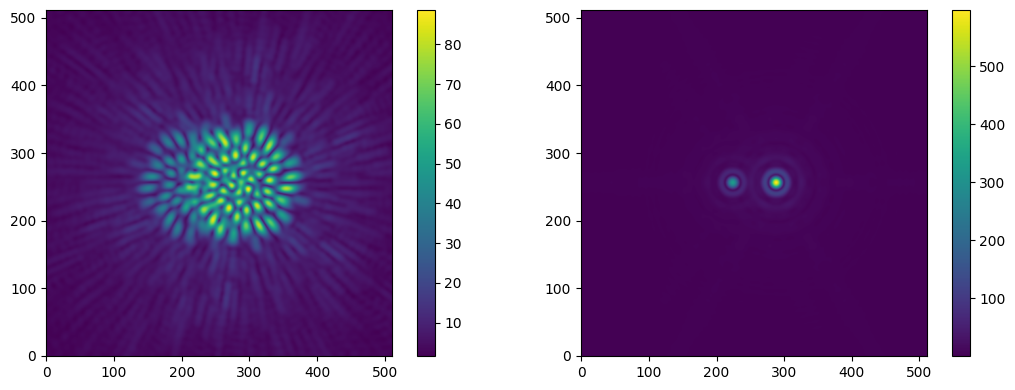

In [32]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.imshow(data**0.5)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(data_airy**0.5)
plt.colorbar()

plt.tight_layout()
plt.show()


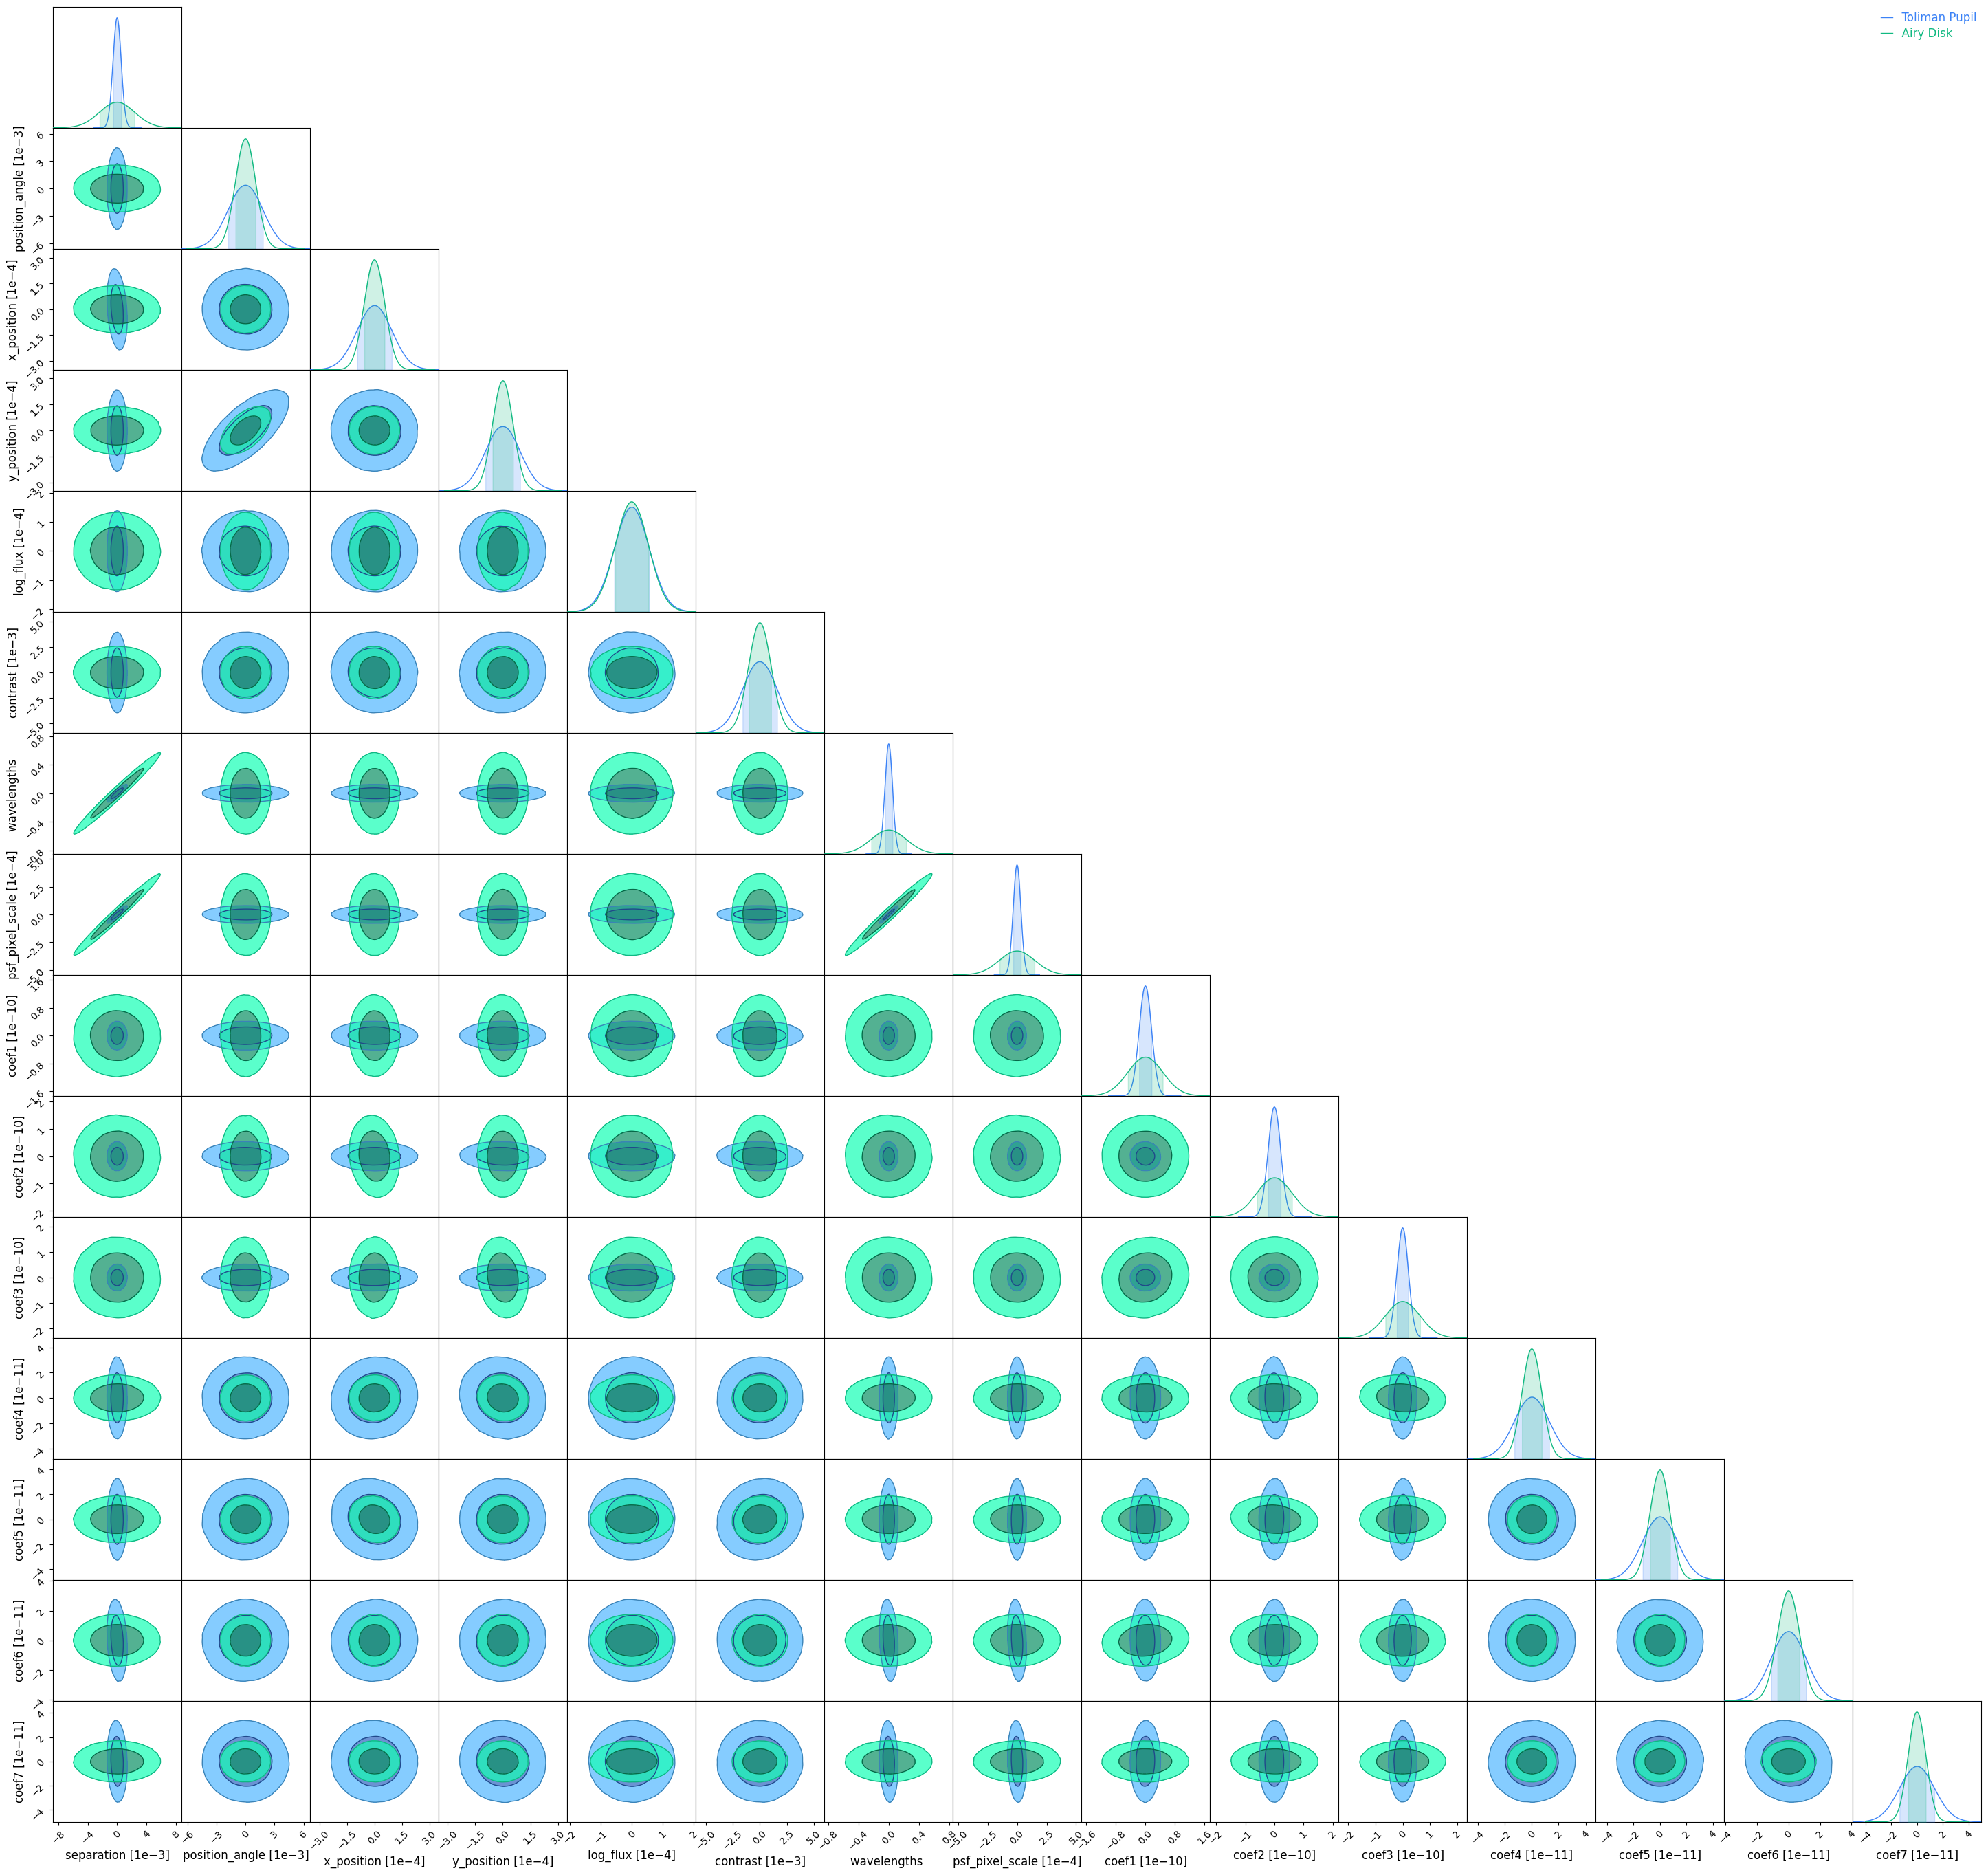

In [33]:
from chainconsumer import ChainConsumer, Chain
param_names = ['separation', 'position_angle', 'x_position', 'y_position', 'log_flux', 'contrast', 'wavelengths', 
    'psf_pixel_scale', 'coef1', 'coef2', 'coef3', 'coef4', 'coef5', 'coef6', 'coef7']
X = np.zeros(len(param_names))

c = ChainConsumer()

# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=cov_init, columns=param_names, name="Initial 'Flippy' Grating")
# )
c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov, columns=param_names, name="Toliman Pupil")
)
c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_airy, columns=param_names, name='Airy Disk')
)
# toliman
# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=cov_tol, columns=param_names, name="Toliman Pupil 'Flippy' Sidelobe")
# )

fig = c.plotter.plot()
# Curious

In [8]:
print(source)

AlphaCen(
  separation=10.0,
  position_angle=90.0,
  x_position=0.0,
  y_position=0.0,
  log_flux=7.832,
  contrast=3.37,
  bandpass=(530, 640),
  weights=f64[2,5],
  wavelengths=f64[5]
)
